In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean, cosine, cityblock
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
from tqdm import tqdm

In [3]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
articles = '/content/drive/MyDrive/Colab Notebooks/articles.xlsx'
customers = '/content/drive/MyDrive/Colab Notebooks/users_test.xlsx'
transaction_val = '/content/drive/MyDrive/Colab Notebooks/transactions_val.xlsx'
users_test = '/content/drive/MyDrive/Colab Notebooks/users_test.xlsx'
transactions_train = '/content/drive/MyDrive/Colab Notebooks/transactions_train.csv'

In [6]:
df_articles = pd.read_excel(articles)
# df_customers = pd.read_excel(customers)
df_transaction_val = pd.read_excel(transaction_val)
# df_users_test = pd.read_excel(users_test)
df_transaction_train = pd.read_csv(transactions_train)

In [7]:
print(df_transaction_train.shape)
df_train = df_transaction_train.sample(500000)
print(df_train.shape)

(1318501, 6)
(500000, 6)


In [8]:
print(df_articles.shape)
df_articles.dropna(inplace=True)
print(df_articles.shape)

(77650, 18)
(77364, 18)


In [9]:
article_index = df_articles.reset_index()["article_id"].astype(int)
article_index.head(2)

0    108775015
1    108775044
Name: article_id, dtype: int64

In [10]:
descriptions = df_articles["detail_desc"].astype(str).tolist()
descriptions_tensor = tf.convert_to_tensor(descriptions)
embeddings = embed(descriptions)
embeddings_df = pd.DataFrame(embeddings.numpy())
embeddings_df.shape

(77364, 512)

In [11]:
df_transaction_train.drop(labels=['Unnamed: 0', 't_dat', 'price', 'sales_channel_id'], axis=1, inplace=True)
df_transaction_train.dropna(inplace=True)
df_transaction_train["article_id"] = df_transaction_train["article_id"].astype(int)
df_transaction_train.head(3)

,customer_id,article_id
0,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001
1,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014
2,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002


In [12]:
pca10 = PCA(10)
embeddings_pca10 = pca10.fit_transform(embeddings_df)
pre_df10 = pd.DataFrame(embeddings_pca10)
dfpca10 = pd.concat([article_index, pre_df10], axis=1)
dfpca10.set_index('article_id', inplace=True)

pca50 = PCA(50)
embeddings_pca50 = pca50.fit_transform(embeddings_df)
pre_df50 = pd.DataFrame(embeddings_pca50)
dfpca50 = pd.concat([article_index, pre_df50], axis=1)
dfpca50.set_index('article_id', inplace=True)

pca100 = PCA(100)
embeddings_pca100 = pca100.fit_transform(embeddings_df)
pre_df100 = pd.DataFrame(embeddings_pca100)
dfpca100 = pd.concat([article_index, pre_df100], axis=1)
dfpca100.set_index('article_id', inplace=True)

In [13]:
vectorize10 = df_transaction_train.merge(dfpca10, left_on='article_id', right_on='article_id')
vectorize10 = vectorize10.groupby('customer_id').sum()/vectorize10.groupby("customer_id").count()
vectorize10.drop("article_id", axis=1, inplace=True)

vectorize50 = df_transaction_train.merge(dfpca50, left_on='article_id', right_on='article_id')
vectorize50 = vectorize50.groupby('customer_id').sum()/vectorize50.groupby("customer_id").count()
vectorize50.drop("article_id", axis=1, inplace=True)

vectorize100 = df_transaction_train.merge(dfpca100, left_on='article_id', right_on='article_id')
vectorize100 = vectorize100.groupby('customer_id').sum()/vectorize100.groupby("customer_id").count()
vectorize100.drop("article_id", axis=1, inplace=True)

In [14]:
def recommend(dfpca, user, topk, metric):
  if metric == "euclideana":
    dfpca["distance"] = np.linalg.norm(dfpca.values - user.values, axis=1)
  elif metric == "coseno":
      dfpca_norm = np.linalg.norm(dfpca.values, axis=1)
      user_norm = np.linalg.norm(user.values)
      cosine_similarity = np.dot(dfpca.values, user.values) / (dfpca_norm * user_norm)
      dfpca["distance"] = 1 - cosine_similarity
  elif metric == "manhattan":
      dfpca["distance"] = np.sum(np.abs(dfpca.values - user.values), axis=1)

  dfpca= dfpca.sort_values("distance", ascending=True)
  topkr = dfpca.iloc[0:topk]
  dfpca.drop(labels=['distance'], axis=1, inplace=True)

  return list(topkr.reset_index()['article_id'].astype(int))

In [15]:
# Métricas de evaluación
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def recall_at_k(r, k):
    r = np.asarray(r)[:k] != 0
    if np.sum(r) == 0:
        return 0.
    return np.sum(r) / np.sum(r != 0)

In [16]:
print(df_transaction_val.shape)
df_val_min = df_transaction_val.sample(5000)
print(df_val_min.shape)

(140312, 6)
(5000, 6)


In [17]:
user_items = {}

for row in df_val_min.itertuples():
    if row[3] not in user_items:
        user_items[row[3]] = []

    user_items[row[3]].append(row[4])

In [18]:
# vectorize: users
# pca: items

def evaluate_model(dfpca, vectorize, metric):
  mean_map = 0.
  mean_ndcg = 0.
  mean_recall = 0.
  for index_user in tqdm(user_items):
    if index_user in vectorize.index:
      rec = recommend(dfpca, vectorize.loc[index_user], 10, metric)
      dfpca.drop(labels=['distance'], axis=1, inplace=True)
      rel_vector = [np.isin(user_items[vectorize.loc[index_user].name], rec, assume_unique=True).astype(int)]
      mean_map += mean_average_precision(rel_vector)
      mean_ndcg += ndcg_at_k(rel_vector, 10)
      mean_recall += recall_at_k(rel_vector, 10)

  mean_map /= len(user_items)
  mean_ndcg /= len(user_items)
  mean_recall /= len(user_items)

  return mean_map, mean_ndcg, mean_recall

In [19]:
metrics = {}

In [20]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca10, vectorize10, "euclideana")
metrics[10, "Euclideana"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [01:50<00:00, 41.84it/s]


In [21]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca10, vectorize10, "coseno")
metrics[10, "Coseno"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [02:30<00:00, 30.86it/s]


In [22]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca10, vectorize10, "manhattan")
metrics[10, "Manhattan"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [01:45<00:00, 43.78it/s]


In [23]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca50, vectorize50, "euclideana")
metrics[50, "Euclideana"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [03:26<00:00, 22.42it/s]


In [24]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca50, vectorize50, "coseno")
metrics[50, "Coseno"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [04:56<00:00, 15.68it/s]


In [25]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca50, vectorize50, "manhattan")
metrics[50, "Manhattan"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [03:21<00:00, 23.00it/s]


In [26]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca100, vectorize100, "euclideana")
metrics[100, "Euclideana"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [05:28<00:00, 14.12it/s]


In [27]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca100, vectorize100, "coseno")
metrics[100, "Coseno"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [07:04<00:00, 10.93it/s]


In [28]:
mean_map, mean_ndcg, mean_recall = evaluate_model(dfpca100, vectorize100, "manhattan")
metrics[100, "Manhattan"] = mean_map, mean_ndcg, mean_recall

100%|██████████| 4641/4641 [05:40<00:00, 13.62it/s]


In [29]:
print(metrics)

{(10, 'Euclideana'): (0.0007541478129713424, 0.0008618832148243913, 0.0008618832148243913), (10, 'Coseno'): (0.001292824822236587, 0.001292824822236587, 0.001292824822236587), (10, 'Manhattan'): (0.0007541478129713424, 0.0008618832148243913, 0.0008618832148243913), (50, 'Euclideana'): (0.0019392372333548805, 0.0019392372333548805, 0.0019392372333548805), (50, 'Coseno'): (0.003447532859297565, 0.003447532859297565, 0.003447532859297565), (50, 'Manhattan'): (0.0030165912518853697, 0.003232062055591467, 0.003232062055591467), (100, 'Euclideana'): (0.004740357681534152, 0.00495582848524025, 0.00495582848524025), (100, 'Coseno'): (0.0070028011204481795, 0.007110536522301228, 0.007110536522301228), (100, 'Manhattan'): (0.004848093083387201, 0.005171299288946348, 0.005171299288946348)}


In [31]:
import json

metrics_str_keys = {str(k): v for k, v in metrics.items()}

with open('/content/drive/MyDrive/Colab Notebooks/results.json', 'w') as f:
    json.dump(metrics_str_keys, f)

In [39]:
df = pd.DataFrame(metrics_str_keys).T
df.columns = ['MAP', 'NDCG', 'Recall']
print(df)

                          MAP      NDCG    Recall
(10, 'Euclideana')   0.000754  0.000862  0.000862
(10, 'Coseno')       0.001293  0.001293  0.001293
(10, 'Manhattan')    0.000754  0.000862  0.000862
(50, 'Euclideana')   0.001939  0.001939  0.001939
(50, 'Coseno')       0.003448  0.003448  0.003448
(50, 'Manhattan')    0.003017  0.003232  0.003232
(100, 'Euclideana')  0.004740  0.004956  0.004956
(100, 'Coseno')      0.007003  0.007111  0.007111
(100, 'Manhattan')   0.004848  0.005171  0.005171


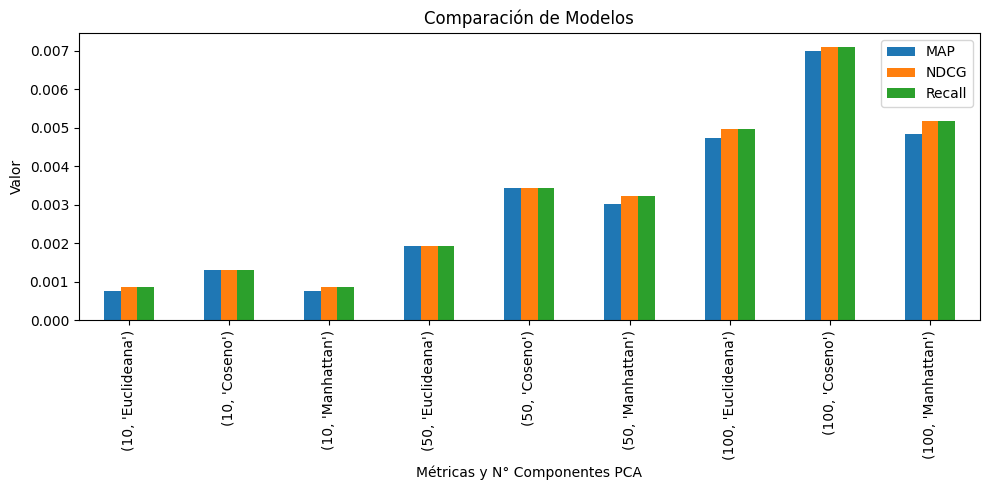

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(kind='bar', ax=ax)
ax.set_xlabel('Métricas y N° Componentes PCA')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Modelos')
ax.legend(['MAP', 'NDCG', 'Recall'])
plt.tight_layout()
plt.show()


De todas las combinaciones, tanto para PCA con n=10, n=50, n=100 y métricas tanto euclideana, manhattan y coseno se obtuvo un mayor MAP, NDCG y Recall para 100 componentes con la métrica coseno. Esto en cuanto a tiempo fue lo más lento pero a la vez más preciso, y vemos que a medida que hay más componentes mayores son las métricas de evaluación. Cabe destacar que se hicieron con el top 10 ranking de items.
